In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomUniform, RandomNormal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Reshape, BatchNormalization
from tensorflow.keras.layers import AveragePooling1D, SeparableConv2D, Activation, concatenate, Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.linear_model import RidgeCV
from tensorflow.keras.constraints import non_neg
warnings.resetwarnings()

# Model prototyping

The goal of this notebook is to get a feel for the performance of the two different types of models to be trained.
Specifically, comparison will be made between a naive baseline model, a ridge regression model, and a convolutional neural network model. Because this notebook is simply prototyping, a very small subset of the available data will be used; a single 
feature's time series for a single country, the United States. This single feature is all that will be available to the CNN and Ridge regression models; because eventually the feature data used in the regression is much larger than that used in the CNN training, this might be an unfair comparison.

The main issue for using a very small subset of data is that I believe it will affect the CNN more than the regression, because
the small number of samples influences how well the specific architecture will perform. Regardless I will press on and continue this testing. 

Both will use mean squared error as their loss function, unfortunately this means that I have to use RidgeCV, which means I need to provide my own folds in order to respect time ordering.

Much like how in regression we want to include multiple days of information for prediction,  it may also be benefitial to convolve multiple frames together for the CNN?

For the baseline testing, the ridge regression seems to benefit more from having more features, but in order to make the tests as simir

In [2]:
def country_slice(data, locations):
    # used as convenience function with pandas
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    # used as convenience function with pandas, used to slice custom time index
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True):
    # plot time series for all countries
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    # plot Series for all times (not useful, I meant to do something else)
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

def column_search(df, name, return_style='loc', threshold='contains'):
    # Due to redundant data and large number of columns, remembering the
    # exact names can be a chore. 
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None

def residual_plot(y_test, y_predict, title='', ax=None):
    # plot the residuals
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
    return None

def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    for max_date_in_frame in range(start_date, time_index.max() - n_days_into_future + 2):
        frame_data = model_data[(time_index <= max_date_in_frame-1) & 
                                (time_index >= max_date_in_frame-frame_size)]
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)

        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_frame == start_date:
            print('Starting with frame ranging time_index values:', max_date_in_frame-frame_size, max_date_in_frame - 1)
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    print('Ending with frame ranging time_index values:', max_date_in_frame-frame_size, max_date_in_frame - 1)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, train_test_only=False, model_type='cnn'):
    """ Split into training, validation and test data.
    """
    
    # the indices for the train-validate-test splits for when the predictors are put in a 2-d format.
    train_indices = list(range(n_countries*0, n_countries*(len(X)-(n_validation_frames+n_test_frames))))
    validate_indices = list(range(n_countries*(len(X)-(n_validation_frames+n_test_frames)), n_countries*(len(X)-n_test_frames)))
    test_indices = list(range(n_countries*(len(X)-n_test_frames), n_countries*len(X)))
    indices = (train_indices, validate_indices, test_indices)

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)

    return splits, indices


def flatten_Xy_splits(splits):
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    X_train_flat =np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
    X_validate_flat =np.concatenate(X_validate.reshape(X_validate.shape[0], X_validate.shape[1], -1), axis=0)
    X_test_flat =np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
    y_train_flat = y_train.ravel()
    y_validate_flat = y_validate.ravel()
    y_test_flat = y_test.ravel()
    flat_splits = (X_train_flat , y_train_flat , X_validate_flat , y_validate_flat , X_test_flat , y_test_flat )
    return flat_splits

def model_analysis(y_true, y_naive, y_predict, n_countries, title='',suptitle='',figname=None, scale=None, s=None):
    print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
    #     y_predict[y_predict<0]=0
    # compute scores 
    mse_naive = mean_squared_error(y_true.ravel(), y_naive.ravel())
    mse_predict = mean_squared_error(y_true.ravel(), y_predict)
    r2_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
    r2_predict = explained_variance_score(y_true.ravel(), y_predict)

    print('{}-step MSE [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, mse_naive, mse_predict))
    print('{}-step R^2 [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, r2_naive, r2_predict))

    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    (ax1,ax2,ax3,ax4) = axes.flatten()
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    
    ax1.text(0.0, ymax,'$MSE$ = {}'.format(np.round(mse_naive,3)),fontsize=14)
    ax1.text(0.0, 0.9*ymax,'$R^2$ = {}'.format(np.round(r2_naive,3)),fontsize=14)
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')
             
    ax2.text(0.0, ymax,'$MSE$ = {}'.format(np.round(mse_predict,3)),fontsize=14)
    ax2.text(0.0, 0.9*ymax,'$R^2$ = {}'.format(np.round(r2_predict,3)),fontsize=14)
    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)

    
    xrange = range(len(y_true))
    if scale=='log':
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    else:
        residual_plot(y_true,y_naive, ax=ax3)
        residual_plot(y_true,y_predict, ax=ax4)
    ax3.set_title('')
    ax4.set_title('')
    ax3.set_ylabel('Residual')
    ax4.set_ylabel('Residual')
    ax3.grid(True)
    ax4.grid(True)
    
    if figname is not None:
        plt.savefig(figname, bbox_inches='tight')
        
    plt.show()
    return None


def normalize_Xy(splits, feature_range=(0., 1.0), normalization_method='minmax',
                        train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    Normalize with respect to some absolute max, just choose 2*absolute max of training set. 

    """
    
    min_, max_ = feature_range
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    feature_minima = X_train[:,:,:,:].min((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_maxima = 2*X_train[:,:,:,:].max((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_denominator = feature_maxima-feature_minima
    # get the shape of each split's array, so that array arithmetic can be done. 
    train_tile_shape = np.array(np.array(X_train.shape)/np.array(feature_maxima.shape),int)
    validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(feature_maxima.shape),int)
    test_tile_shape = np.array(np.array(X_test.shape)/np.array(feature_maxima.shape),int)

    # using X - X_min / (X_max-X_min). Form denominator
    train_denominator = np.tile(feature_denominator, train_tile_shape)
    validate_denominator = np.tile(feature_denominator, validate_tile_shape)
    test_denominator = np.tile(feature_denominator, test_tile_shape)
    
    # and then the minima.
    train_minima = np.tile(feature_minima,train_tile_shape)
    validate_minima = np.tile(feature_minima,validate_tile_shape)
    test_minima = np.tile(feature_minima,test_tile_shape)
    
    # factor of 1/max_ accounts for absolute maximum that is outside of the data (i.e. potential future values). 
    X_train_scaled = (max_-min_)*(X_train - train_minima)/train_denominator
    X_validate_scaled = (max_-min_)*(X_validate - validate_minima)/validate_denominator
    X_test_scaled = (max_-min_)*(X_test - test_minima)/test_denominator

    
    scaled_splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test) 
    scaling_arrays =  (feature_maxima, feature_minima, feature_denominator)

    return scaled_splits, scaling_arrays

In [3]:
# Import cleaned data produced by other notebook. 
global_data = pd.read_csv('cnn_data.csv',index_col=0)

For the prototype, see what kind of result we get with just the data on the United States, and only use the new_cases_per_million feature.

In [4]:
data = global_data[global_data.location=='United States'].reset_index(drop=True)
# not enough countries have new_recovered_weighted values.
data = data.drop(columns=['date'])
data = data.drop(columns=column_search(data, 'log'))
# data = data[data.time_index>=40]

# Data

Create the predictors (X) and the target variable (y) which contain the feature information and the time-shifted new cases per million values, used for prediction, respectively.

By iterating over possible leading window dates a 4-d tensor with dimensions given by the following is created:
```X.shape = (n_frames, n_countries, n_time_steps, n_features)```

Now, splitting X intro train, validate, test, is as easy as slicing the first axis. 
Going backwards in time, the testing set contains the next to last most recent day's worth of values. It's not
the last day because the last day has no "future" with which to compare, and so no worthwhile prediction can be
made. The test set is defined by slicing X for its last row(s) (plural if n_test_frames > 1). The validation set that will 
be used is the next 7 days worth of values and the training data is everything else.

The keras api expects a three dimensional tensor, and so after the slicing/partitioning into different sets, the first axis
is concatenated such that the effect dimensions are ```(n_frames*n_countries, n_time_steps, n_features)```.
This is done via the function ```flatten_Xy```. Technically, when initializing the model it expects a 2-d shape. This is because the data is organized as ```(batch_size, time_steps, features)```. In other words, when initializing the model, one gives the api a shape of a single sample. 


Next, it is important to rescale the data, For this purpose, create some arbitrary maximum (twice the normal max) and
use this to rescale values to the interval [0,1] (such that the fictitious maximum equals 1).

# Fully connected neural network model

The first need is that the data has to be arranged in a manner that is compatible with the keras API.
This is done by the primary functions I have written to take in a DataFrame and a series of target values,
and then slice all values according to different time frames. First create said dataframe and initialize
the quantities relevant to data splitting.

In [5]:
model_data = data.copy().loc[:, 'new_cases_per_million'].to_frame()
new_cases_index = column_search(model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
model_data = model_data.iloc[:, new_cases_index].to_frame(); new_cases_index=0
n_countries = data.location.nunique()
target_data = data.new_cases_per_million
time_index = data.time_index

frame_size = 28
start_date = frame_size + data.time_index.min()

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

In [6]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


In [7]:
scaled_splits, scaling_arrays =  normalize_Xy(splits, feature_range=(0,1.0), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
# if need to supply folds for sklearn CV regression functions.
(X_nn_train, y_nn_train, X_nn_validate, y_nn_validate, X_nn_test, y_nn_test) = scaled_splits
(train_indices, validate_indices, test_indices) = indices

To ensure that the data has been split correctly, and has the correct values, plot the scaled data's splits based on color, as well as the original supposed order. The order of the values is correct if the original values are black circles directly behind the colored train-validate-test splits circles'.

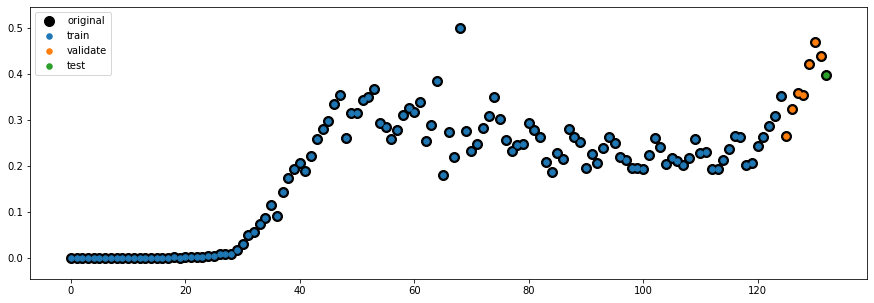

In [8]:
X_scaled_tmp = np.concatenate((X_nn_train,X_nn_validate,X_nn_test), axis=0)

fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.scatter(range(len(X_scaled_tmp)), X_scaled_tmp[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=100,color='k', label='original')
ax.scatter(range(len(scaled_splits[0])), scaled_splits[0][:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30, label='train')
ax.scatter(range(len(scaled_splits[0]), len(scaled_splits[0])+len(scaled_splits[2])), scaled_splits[2][:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30, label='validate')
ax.scatter(range(len(scaled_splits[0])+len(scaled_splits[2]), len(X)), X_nn_test[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30, label='test')
plt.legend()
_ = plt.show()

Scatter plots of train, validate, test sets, by plotting all values in black first I can ensure that the points
are correctly ordered and at the correct values because it makes the rest of the points look like they have black borders.

In [9]:
X_nn_train_model = np.concatenate(X_nn_train.reshape(X_nn_train.shape[0], X_nn_train.shape[1], -1), axis=0)[:,:,np.newaxis]
X_nn_validate_model = np.concatenate(X_nn_validate.reshape(X_nn_validate.shape[0], X_nn_validate.shape[1], -1), axis=0)[:,:,np.newaxis]
X_nn_test_model = np.concatenate(X_nn_test.reshape(X_nn_test.shape[0], X_nn_test.shape[1], -1), axis=0)[:,:,np.newaxis]
y_nn_train_model = y_nn_train.ravel()
y_nn_validate_model = y_nn_validate.ravel()
y_nn_test_model = y_nn_test.ravel()

X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()

To get the correct arrays for the naive baseline, take the values from X instead of y, as y is shifted and makes the process more confusing and or susceptible to mistakes.

The model itself is straightforward. Two dense layers followed by a ReLU activation layer with a single, predictive, output. I try to keep the parameter number at a minimum due to the number of samples currently; and the fact that this trial run is only using a single feature. 

In [10]:
kernel0 = RandomNormal(seed=0)
kernel1 = RandomNormal(seed=1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
epochs = 10000
learning_rate = 0.001
batch_size = 32

nn_input = Input(shape=X_nn_train.shape[2:])
flat = Flatten()(nn_input)
dense0 = Dense(int(flat.shape[1].value), 
                use_bias=False,
               kernel_initializer=kernel0,

               )(flat)
dense1 = Dense(1, 
                activation='relu',
                use_bias=False,
                kernel_initializer=kernel1,

               )(dense0)

nn = Model(inputs=nn_input, outputs=dense1)
nn.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

In [12]:
nn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 1)]           0         
_________________________________________________________________
flatten (Flatten)            (None, 28)                0         
_________________________________________________________________
dense (Dense)                (None, 28)                784       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 28        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________


Fit the model to the scaled training and validation data. 

In [13]:
history = nn.fit(X_nn_train_model, y_nn_train_model, epochs=epochs, validation_data=(X_nn_validate_model, y_nn_validate_model), 
          batch_size=batch_size, verbose=0)

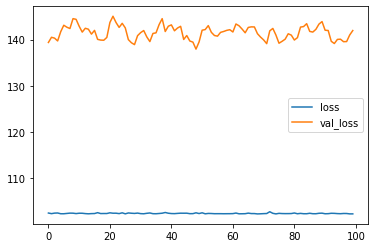

In [14]:
_ = plt.plot(history.history['loss'][-100:], label='loss')
_ = plt.plot(history.history['val_loss'][-100:], label='val_loss')
_ = plt.legend()
_ = plt.show()

There were 0 negative predictions
1-step MSE [Naive, NN model] = [198.382250792,102.31150927186866]
1-step R^2 [Naive, NN model] = [0.8413462380389802,0.9186583337682795]


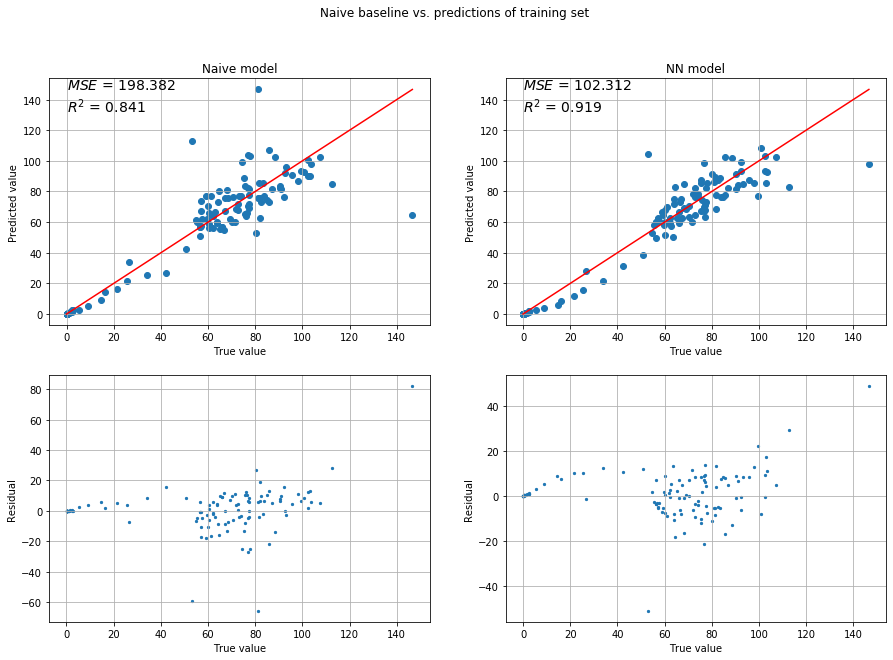

In [15]:
y_true = y_nn_train_model.ravel()
y_predict = nn.predict(X_nn_train_model).ravel()
y_naive = y_train_naive
model_analysis(y_true, y_train_naive, y_predict, n_countries, title='NN model', 
               suptitle='Naive baseline vs. predictions of training set',
              figname='nn_prototype_train_performance.jpg')

There were 0 negative predictions
1-step MSE [Naive, nn model] = [170.80669257142873,141.93755700371122]
1-step R^2 [Naive, nn model] = [0.2994526992709322,0.4986225037759332]


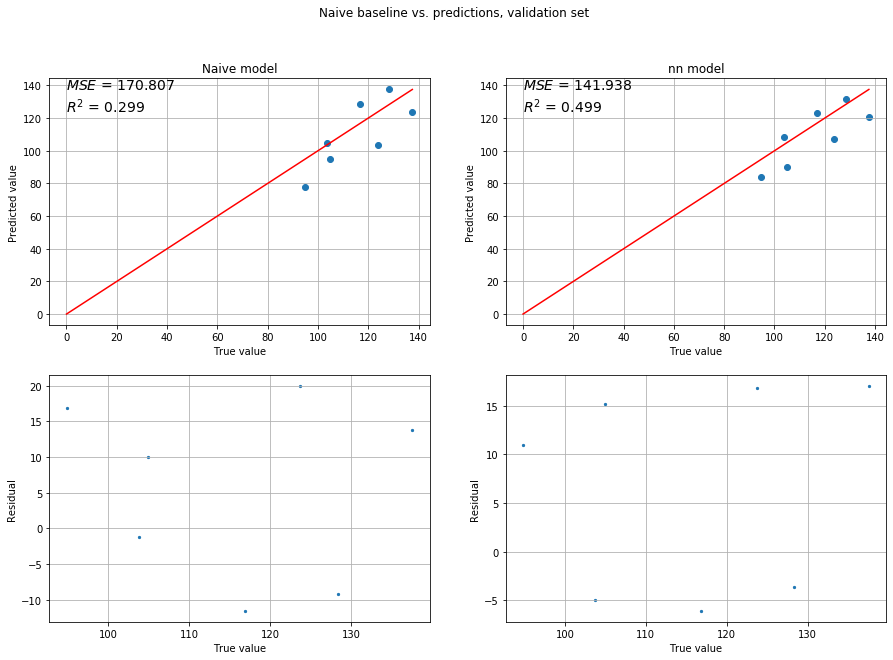

In [49]:

y_true =  y_nn_validate_model.ravel()
y_predict = nn.predict(X_nn_validate_model).ravel()
y_naive = y_validate_naive
model_analysis(y_true, y_naive, y_predict, n_countries, title='nn model',
               suptitle='Naive baseline vs. predictions, validation set',
              figname='nn_prototype_validate_performance.jpg')

# Convolutional neural network model
<a id='cnn'></a>
[Return to table of contents](#toc)


The convolution will be with respect to time, specifically the time steps within frames of time of predetermined length. This brings along with it a number of important details and challenges, such as ensuring the convolution is indeed in the right dimension and that time-ordering is being respected by the training and validation process. The manner in which this is handled also has to be compatible with the keras API. The preprocessing is the same as that for the neural network, only that this time the input is not flattened until after the convolutional layers. So, proceeding as before, I do some redundant calculations here for the sake of modularity:

In [17]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)

scaled_splits, scaling_arrays =  normalize_Xy(splits, feature_range=(0,1.0), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
# if need to supply folds for sklearn CV regression functions.
(X_cnn_train, y_cnn_train, X_cnn_validate, y_cnn_validate, X_cnn_test, y_cnn_test) = splits
(train_indices, validate_indices, test_indices) = indices

X_cnn_train_model = np.concatenate(X_cnn_train.reshape(X_cnn_train.shape[0], X_cnn_train.shape[1], -1), axis=0)[:,:,np.newaxis]
X_cnn_validate_model = np.concatenate(X_cnn_validate.reshape(X_cnn_validate.shape[0], X_cnn_validate.shape[1], -1), axis=0)[:,:,np.newaxis]
X_cnn_test_model = np.concatenate(X_cnn_test.reshape(X_cnn_test.shape[0], X_cnn_test.shape[1], -1), axis=0)[:,:,np.newaxis]
y_cnn_train_model = y_cnn_train.ravel()
y_cnn_validate_model = y_cnn_validate.ravel()
y_cnn_test_model = y_cnn_test.ravel()

X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


The architecture of the CNN itself is two convolutional layers followed by two dense layers, ending with a ReLU activation layer. The parameters for the convolutional layers are the number of filters and the kernel size of the convolutions. The number of filters is much larger than the second because the desire is to pick up on many small patterns and then use them in combination to form larger ones. As far as I know this is the best way of doing so. There is no real argument for the convolutional kernel size other than they cannot be too large because the number of time steps are themselves small in number.

In [18]:
kernel0 = RandomNormal(seed=0)
kernel1 = RandomNormal(seed=1)
kernel2 = RandomNormal(seed=2)
kernel3 = RandomNormal(seed=3)

In [19]:
epochs = 1000
learning_rate = 0.001
kernel = 4
N = 8
FC = 8
batch_size = X_cnn_train.shape[0]

f1, f2 = 64, 4
k1, k2 = 4, 4

cnn = Sequential()


cnn.add(Conv1D(filters=int(f1), kernel_size=int(k1),
                 padding='valid',
                 input_shape=X_cnn_train.shape[2:],
               kernel_initializer=kernel0,
                )
         )

cnn.add(Conv1D(filters=int(f2), 
                 kernel_size=int(k2), 
                 padding='valid',
               kernel_initializer=kernel1,
                )
         )

cnn.add(Flatten())


cnn.add(Dense(cnn.output.shape[1],
              kernel_initializer=kernel2,
             )
       )


cnn.add(Dense(1, 
                activation='relu',
              kernel_initializer=kernel3,

                   ))
cnn.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py:61: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif not isinstance(value, collections.Sized):


Fit the model.

In [20]:
history = cnn.fit(X_cnn_train_model, y_cnn_train_model, epochs=epochs, validation_data=(X_cnn_validate_model, y_cnn_validate_model), 
          batch_size=batch_size, verbose=0)

Plot the training and validation loss curves to check for overfitting.

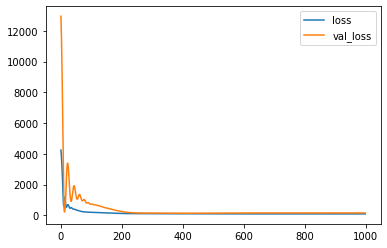

In [21]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

Plot the results of predicting the training set.

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [198.382250792,99.1561981143581]
1-step R^2 [Naive, CNN model] = [0.8413462380389802,0.9205454849502827]


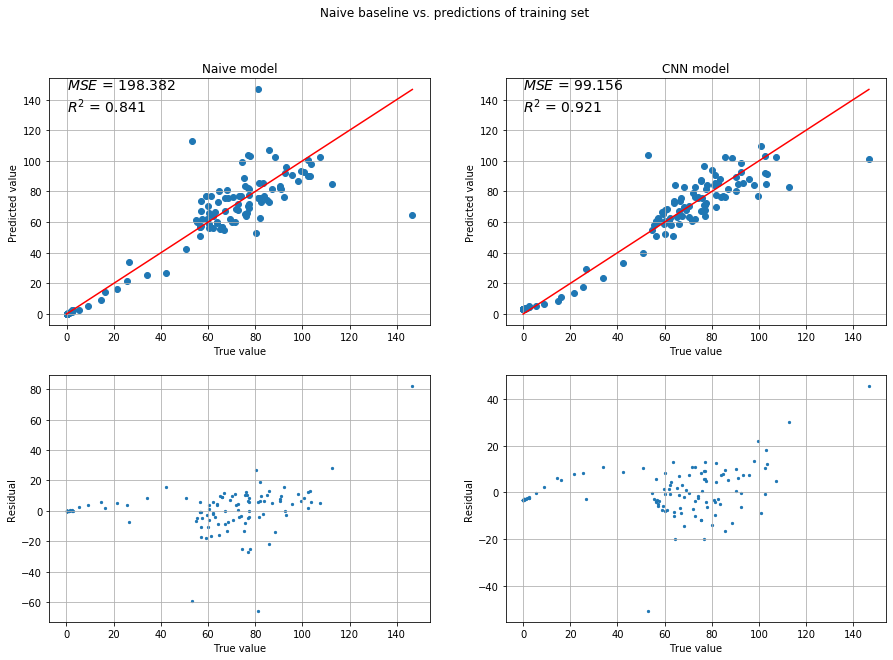

In [22]:
y_true = y_cnn_train_model.ravel()
y_predict =  cnn.predict(X_cnn_train_model).ravel()
y_naive = y_train_naive
model_analysis(y_true, y_naive, y_predict, n_countries, title='CNN model',
               suptitle='Naive baseline vs. predictions, validation set',
              figname='cnn_prototype_train_performance.jpg')

Plot the results of predicting the validation set.

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,163.46397597044898]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.5233299730206791]


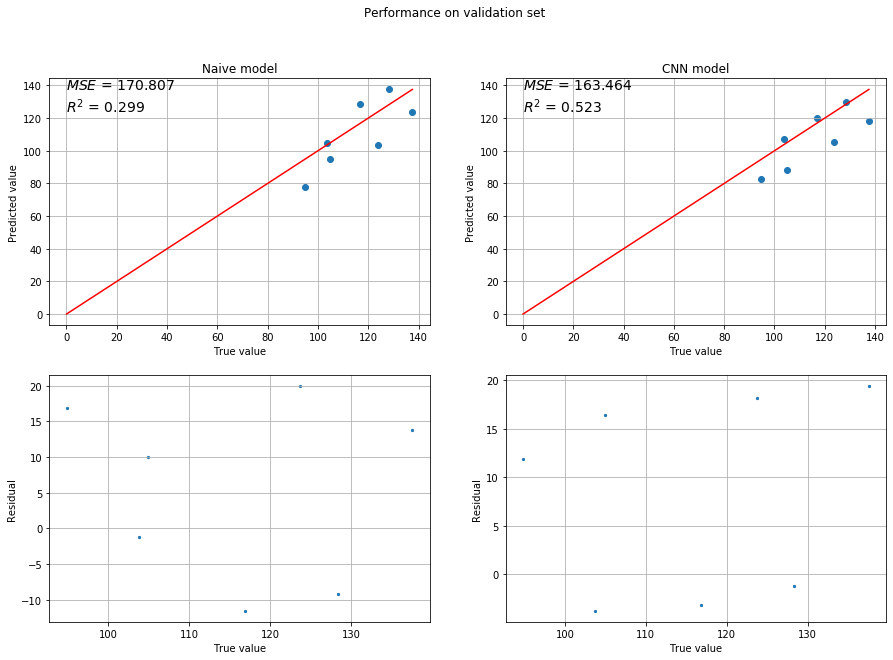

137.543 146.612 129.58788


In [23]:

y_true =  y_cnn_validate_model.ravel()
y_predict = cnn.predict(X_cnn_validate_model).ravel()
y_naive = y_validate_naive
model_analysis(y_true, y_naive, y_predict, n_countries, title='CNN model',
               suptitle='Naive baseline vs. predictions, validation set',
              figname='cnn_prototype_validate_performance.jpg')

A summary of the network for convenience.

In [24]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 25, 64)            320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 4)             1028      
_________________________________________________________________
flatten_1 (Flatten)          (None, 88)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 88)                7832      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 89        
Total params: 9,269
Trainable params: 9,269
Non-trainable params: 0
_________________________________________________________________


# Ridge Regression with single feature
<a id='regression'></a>
[Return to table of contents](#toc)

For different kinds of comparisons, I will use Ridge regression on two different datasets (technically two different subsets of the same dataset). The first model uses only the single feature used in the neural network modeling; for a "fair" comparison.

I do not use scaling because previous investigations not included here showed that scaling hurt the performance, using mean squared error as a metric. 

In [25]:
r_data = pd.read_csv('regression_data.csv', index_col=0)
r_data = r_data[r_data.location == 'United States']

In [26]:
r_data = pd.read_csv('regression_data.csv', index_col=0)
tmp =pd.read_csv('regression_data_full.csv', index_col=0)
r_data = pd.concat((r_data,tmp.loc[:, column_search(tmp,'government_response')]),axis=1)
r_data = r_data.drop(columns=['date'])
r_data = r_data.drop(columns=column_search(r_data,'test'))
r_data = r_data.drop(columns=column_search(r_data,'deaths'))
r_data = r_data.drop(columns=column_search(r_data,'recovered'))
# r_data = r_data.drop(columns=column_search(r_data,'log'))
r_data = r_data.drop(columns=column_search(r_data,'std'))
r_data = r_data[r_data.location == 'United States']


In [27]:
# pandemic_start_date_median = r_data[r_data.days_since_first_case == 1].time_index.median()
# r_data[r_data.days_since_first_case==int(r_data.time_index.max()-pandemic_start_date_median)].location.nunique()
# new_dates = r_data[r_data.time_index>=60]
# dates_with_days_since_first_case_equals_zero = new_dates.groupby('location').days_since_first_case.min()
# countries_to_drop = dates_with_days_since_first_case[dates_with_days_since_first_case==0].index
# r_data = new_dates[~new_dates.location.isin(countries_to_drop)]

Again for the sake of modularity, perform some redundant calculations.

In [28]:
modeling_features = ['new_cases_per_million', 'government_response_index', 'log_new_cases_per_million']
model_r_data = r_data.copy().loc[:, modeling_features]

In [29]:
new_cases_index = column_search(model_r_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_r_data = r_data.new_cases_per_million
time_index = r_data.time_index

frame_size = 28
start_date = frame_size + r_data.time_index.min()

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

In [30]:
r_model_data = r_data.new_cases_per_million.to_frame().copy(); new_cases_index=0
new_cases_index = column_search(r_model_data,'new_cases_per_million',threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_data = r_data.new_cases_per_million
time_index = r_data.time_index.astype(int)
frame_size = 28
start_date = frame_size + time_index.min()
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

X, y = create_Xy(r_model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames,model_type='ridge')
(train_indices, validate_indices, test_indices) = indices
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)

y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index]
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index]
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index]

flat_splits = flatten_Xy_splits(splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


I want to use a different metric other than explained variance as a metric; the easiest way of doing so is to use RidgeCV and pass it a scoring function. I also provide the indices of the training and testing folds; of which there is only one, so that the data used to train this model and the neural networks are the same. The cross validation ranges over some alpha values (regularization constant).

In [31]:
X_regression = np.concatenate((X_regression_train, X_regression_validate),axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate),axis=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
ridge = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = ridge.fit(X_regression, y_regression)

The predictions of the training set.

There were 0 negative predictions
1-step MSE [Naive, Ridge regression model] = [198.382250792,100.32805106976801]
1-step R^2 [Naive, Ridge regression model] = [0.8413462380389802,0.9196921269889909]


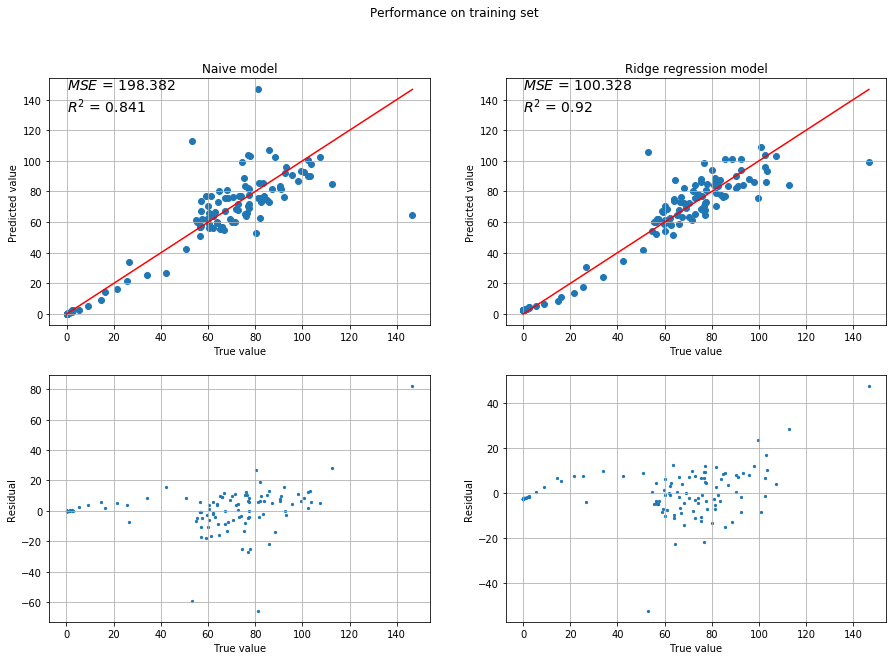

In [32]:
y_predict_train = ridge.predict(X_regression_train).ravel()

model_analysis(y_true, y_naive, y_predict, n_countries, title='Ridge Regression model',
               suptitle='Naive baseline vs. predictions of training set',
              figname='regression_prototype_single_train_performance.jpg')

The predictions of the validation set.

There were 0 negative predictions
1-step MSE [Naive, Ridge regression model] = [170.80669257142873,111.08086446025358]
1-step R^2 [Naive, Ridge regression model] = [0.2994526992709322,0.6146030489864923]


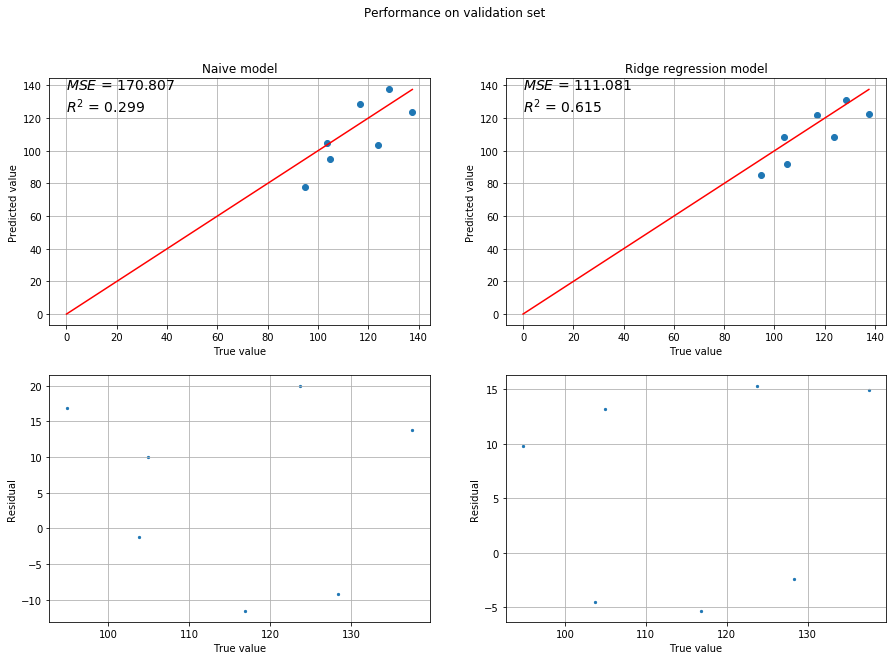

In [33]:
y_true = y_regression_validate
y_predict = ridge_all_features.predict(X_regression_validate).ravel()
y_naive = y_validate_naive
model_analysis(y_true, y_naive, y_predict, n_countries, title='Ridge Regression model',
               suptitle='Naive baseline vs. predictions, validation set',
              figname='regression_prototype_single_validate_performance.jpg')

# Regression with all features
<a id='regression2'></a>
[Return to table of contents](#toc)
This second regression model contains most of the time-dependent features as well as their corresponding rolling features (rolling averages and standard deviations).

This is partly a sneak peak into the notebook on regression, ```COVID19_regression.ipynb``` and partly a demonstration of evidence that supports the claim that regression performs much better with more feature information, in terms of the prediction on the validation set, but actually performs much worse on the testing set. The next few cells are basically the same as above, so they 

In [34]:
r_model_data = r_data.iloc[:,2:].copy()
new_cases_index = column_search(r_model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_data = r_data.new_cases_per_million
time_index = r_data.time_index.astype(int)
frame_size = 28
start_date = frame_size
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

X, y = create_Xy(r_model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames,model_type='ridge')
(train_indices, validate_indices, test_indices) = indices

(X_train, y_train, X_validate,
 y_validate, X_test, y_test) = splits

n_features = X.shape[-1]
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index]
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index]
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index]

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


Before we proceed, let's check that the data is organized as we expect, as this time around we are using more than a single feature.

In [35]:
new_cases_indices = np.ravel_multi_index([list(range(frame_size)),[new_cases_index]],(frame_size, n_features))
new_cases_indices

array([  1,  15,  29,  43,  57,  71,  85,  99, 113, 127, 141, 155, 169,
       183, 197, 211, 225, 239, 253, 267, 281, 295, 309, 323, 337, 351,
       365, 379], dtype=int64)

In [36]:
flat_splits = flatten_Xy_splits(splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

In [37]:
# The first frame should have time values from 0 to 27.
r_model_data.new_cases_per_million.iloc[:frame_size].values-X_regression_train[0, new_cases_indices]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [38]:
# The last row or last frame, should have values from time_index.max()-1-n_test_frames-n_validation_frames-frame_size to time_index.max()-1-n_test_frames-n_validation_frames
(r_model_data.new_cases_per_million.iloc[-frame_size-n_test_frames-n_validation_frames-1:-n_test_frames-n_validation_frames-1].values
 -X_regression_train[-1, new_cases_indices])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Now that the data is at least ordered how I expect, proceed with the modelling.

In [39]:
X_regression = np.concatenate((X_regression_train, X_regression_validate),axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate),axis=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
ridge_all_features = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = ridge_all_features.fit(X_regression, y_regression)

As previously seen, predict on the training and validation data.

There were 12 negative predictions
1-step MSE [Naive, Ridge Regression model] = [198.382250792,39.607781662620546]
1-step R^2 [Naive, Ridge Regression model] = [0.8413462380389802,0.9682877967428889]


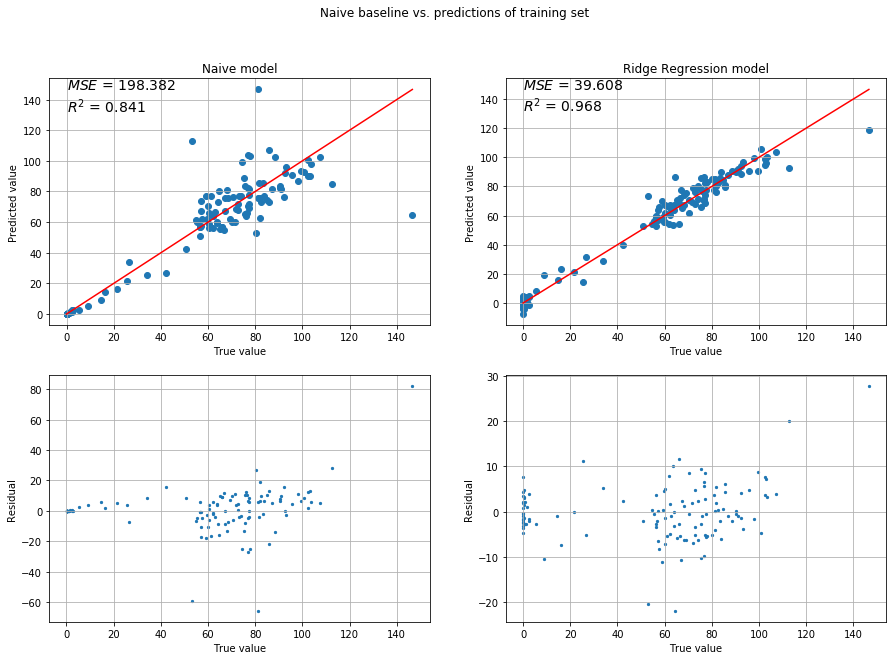

In [40]:
y_predict = ridge_all_features.predict(X_regression_train).ravel()
y_true = y_regression_train
y_naive =y_train_naive
model_analysis(y_true, y_naive, y_predict, n_countries, title='Ridge Regression model',
               suptitle='Naive baseline vs. predictions of training set',
              figname='regression_prototype_train_performance.jpg')

There were 0 negative predictions
1-step MSE [Naive, Ridge Regression model] = [170.80669257142873,66.33861339608104]
1-step R^2 [Naive, Ridge Regression model] = [0.2994526992709322,0.7192343229167091]


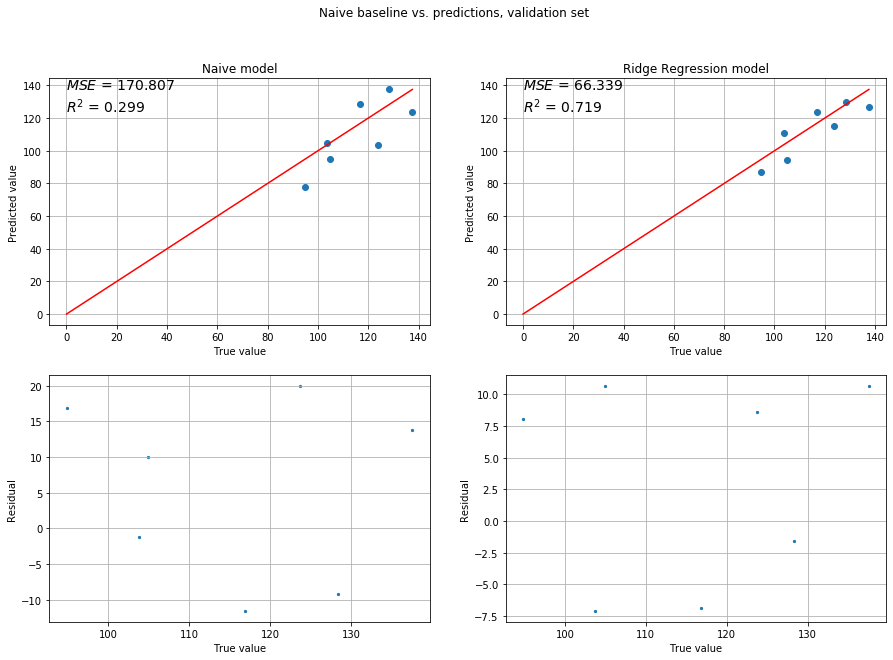

In [46]:
y_true = y_regression_validate
y_predict = ridge_all_features.predict(X_regression_validate).ravel()
y_naive = y_validate_naive
model_analysis(y_true, y_naive, y_predict, n_countries, title='Ridge Regression model',
               suptitle='Naive baseline vs. predictions, validation set',
              figname='regression_prototype_validate_performance.jpg')

## Analysis and conclusion
<a id='conclusion'></a>
[Return to table of contents](#toc)

As a final measure of the potency of each prototype model, perform predictions on the test data. Because these models are only using a single countries data, I do not view this as snooping the holdout set.

In [42]:
y_naive = y_test_naive
y_true = y_test
y_predict_r = ridge_all_features.predict(X_regression_test)
y_predict_c = cnn.predict(X_cnn_test_model)
y_predict_n = nn.predict(X_nn_test_model)

While the ridge regression trained on all of the feature data performs very well on the training and validation sets, it does not perform well on the testing set. Presumably this is because I did not retrain the data on the combination of training and validation; i.e. it is using a model which is only trained up to a week into the past. I find this sufficient for these prototype models, however.

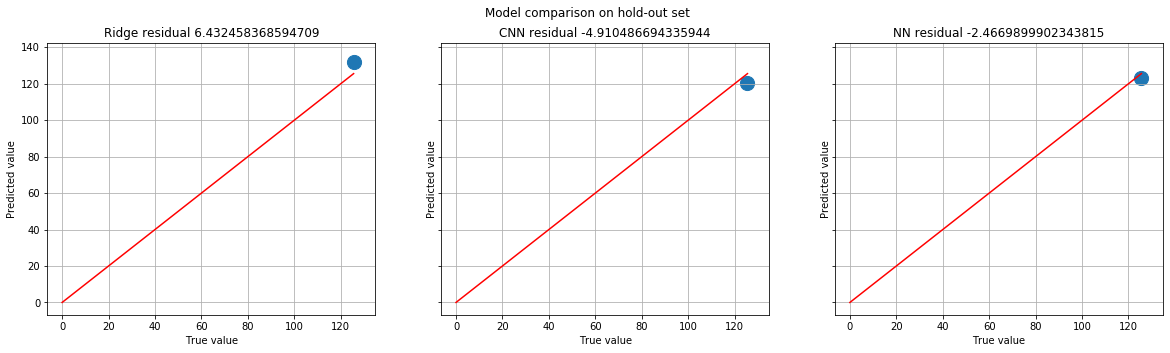

In [43]:
s = 200
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5),sharey=True)

ymax = np.max([y_true.max(), y_predict.max()])
ax1.plot([0, ymax], [0, ymax],color='r')
ax1.scatter(y_true, y_predict_r, s=s)
ax2.plot([0, ymax], [0, ymax],color='r')
ax2.scatter(y_true, y_predict_c, s=s)
ax3.plot([0, ymax], [0, ymax],color='r')
ax3.scatter(y_true, y_predict_n, s=s)

ax1.set_xlabel('True value')
ax1.set_ylabel('Predicted value')
ax1.set_title('Ridge residual '+str(y_predict_r.ravel()[0]-y_true.ravel()[0]))

ax2.set_xlabel('True value')
ax2.set_ylabel('Predicted value')
ax2.set_title('CNN residual '+str(y_predict_c.ravel()[0]-y_true.ravel()[0]))

ax3.set_xlabel('True value')
ax3.set_ylabel('Predicted value')
ax3.set_title('NN residual '+str(y_predict_n.ravel()[0]-y_true.ravel()[0]))

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
plt.suptitle('Model comparison on hold-out set')
plt.show()

# Appendix

Some comments on the relation between X slicing and the original data: 

    X[-1, :, -1, 2] = model_data.time_index.max() - n_days_into_future 
    X[-t, :, -1, 2] = (model_data.time_index.max() - n_days_into_future + 1) - t

Because ```n_days_into_future == 1``` throughout this notebook, the most recent date in the last frame of X is data.time_index.max()-1.
The maximum time_index of the data in y is data.time_index().max(). Therefore, to convert, we have
    
    X[-1,:,-1,:] = y[-2, :]
    
or, more generally, 

    X[-t,:,-1,:] = y[-(n+t), :]
    
This shows that the staggering has been done correctly. That is, each entry along the first axis of X predicts.
Need to make sure that the naive predictions are being chosen correctly. To do so, just look at the instance
where n_frames_validation == 1 and n_frames_test == 1 (to make slicing easier) for n_days_into_future == 7.

Therefore, when n_validation_frames > 1, the breakdown of the data is as follows:

    Naive predictions = X[validation_indices, :, -1, 2]
    CNN predictions = model.predict(X[validation_indices, :, :, :])
    True future values = y[validation_indices, :]
    
Where validation indices is assumed to be a correctly formatted array of indices. 
